In [ ]:
!pip install scikit-learn==1.1.3
!pip install mrmr_selection
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 27.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 1.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 8.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=8f5de3ef59e1e46db77e665be23d25440c338b3f651eb48c331a48669372473d

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mrmr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from mrmr import mrmr_classif

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index
from matplotlib.offsetbox import AnchoredText


In [ ]:
# Connect to google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load flux data  
file1 = pd.read_csv('/content/drive/MyDrive/Data/fluxes.csv', encoding='utf-8')

# Load gene expression data 
file2 = pd.read_csv('/content/drive/MyDrive/Data/gene_expression_data.csv', encoding='utf-8')

# Load survival data 
file3 = pd.read_csv('/content/drive/MyDrive/Data/survival_data.csv', encoding='utf-8')

# Load flux data as the X variable
X_flux = file1

# Load gene expression data as the X variable
X_gex = file2

# Load survival data as the Y variable
Y = file3

In [ ]:
#Rename unnamed (1st) column
X_gex = X_gex.rename(columns={X_gex.columns[0]: 'Risk_factor'})

# Tranpose patient ID  to rows in order to align gene data with fluxes data
X_gex = X_gex.set_index('Risk_factor').T.rename_axis('PatientID').rename_axis(None, axis=1).reset_index()

# Remove 'PatientID' column
X_gex = X_gex.drop(['PatientID'], axis=1)

# Concatenate the gene expression and flux data matrices
X_concat = pd.concat([X_gex, X_flux], axis=1)
X_concat.head()

,AKAP5,G30,TMC3,OR51A2,HOXD4,IBSP,ELAVL2,CXorf22,FLJ32894,LIPK,...,fluxes3779,fluxes3780,fluxes3781,fluxes3782,fluxes3783,fluxes3784,fluxes3785,fluxes3786,fluxes3787,fluxes3788
0,-0.856922,0.513849,-0.942729,0.614422,0.588492,0.277832,0.678194,-1.396616,2.467089,3.293336,...,0,0,0,0,0.0,0,0,0,0,0
1,-0.559035,0.871548,-0.448162,0.810584,-0.382428,0.279705,0.029191,0.178131,0.288021,-0.599110,...,0,0,0,0,0.0,0,0,0,0,0
2,-0.266071,-0.160577,-0.362206,-1.234118,0.908324,0.239631,1.522694,-0.414887,-0.106961,-0.786389,...,0,0,0,0,0.0,0,0,0,0,0
3,-0.261968,-0.673417,-0.103697,0.039013,-0.715968,0.340002,-0.373350,-0.847820,0.016622,-1.420762,...,0,0,0,0,0.0,0,0,0,0,0
4,0.127010,-0.209375,0.337629,-0.640247,0.198601,-1.001897,-0.676351,2.533395,-0.526782,-0.014084,...,0,0,0,0,0.0,0,0,0,0,0


In [ ]:
#Prepare target variable
Y = file3

#Preview data
Y.head()

,PatientID,Time,Event
0,TCGA-A1-A0SD-01A-11R-A114-1,437,0
1,TCGA-A2-A04N-01A-11R-A114-1,3153,0
2,TCGA-A2-A04U-01A-11R-A114-1,670,0
3,TCGA-A2-A04W-01A-31R-A114-1,1918,0
4,TCGA-A2-A0CL-01A-11R-A114-1,1827,0


In [ ]:
# Remove 'PatientID' column
Y = Y.drop(['PatientID'], axis=1)

In [ ]:
#Prepare target variables
Y = file3

Y['Event'] = Y['Event'].astype('bool')

Y['Time'] = Y['Time'].astype('float')

Y = Y[['Event','Time']].to_records(index=False)

In [ ]:
# Normalise concatenated data
ss = MinMaxScaler()

X_concat = pd.DataFrame(ss.fit_transform(X_concat), columns=X_concat.columns)

In [ ]:
# Select features using MRMR
y_mrmr = Y['Time']

features_selected = mrmr_classif(X_concat, y_mrmr, K = 50)

X_selected = X_concat[features_selected]

100%|██████████| 50/50 [05:48<00:00,  6.97s/it]


In [ ]:
# convert target variable to dataframe
Y_df = pd.DataFrame(Y)

# concatenate the predictor and target data for CoxPHFitter
data = pd.concat([X_selected,Y_df],axis=1)

In [ ]:
#Check shape
data.shape

(105, 52)

In [ ]:
#Fit the model
cph = CoxPHFitter(penalizer=0.001,l1_ratio=0.5)
cph.fit(data, duration_col='Time', event_col='Event')

<lifelines.CoxPHFitter: fitted with 105 total observations, 87 right-censored observations>

In [ ]:
# calculate the concordance index
c_index = concordance_index(data['Time'], -cph.predict_partial_hazard(data), data['Event'])
print("Concordance index:", c_index)

Concordance index: 0.776595744680851


In [ ]:
#Check model summary
cph.summary.head()

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
fluxes3,-7.169471e-01,4.882405e-01,3.230885e+01,-6.404113e+01,6.260724e+01,1.539178e-28,1.548741e+27,0.0,-2.219042e-02,0.982296,0.025770
fluxes14,6.612249e-70,1.000000e+00,2.066293e-27,-4.049860e-27,4.049860e-27,1.000000e+00,1.000000e+00,0.0,3.200054e-43,1.000000,-0.000000
fluxes17,1.797469e-48,1.000000e+00,1.577691e-12,-3.092217e-12,3.092217e-12,1.000000e+00,1.000000e+00,0.0,1.139304e-36,1.000000,-0.000000
fluxes24,-1.416908e+01,7.021802e-07,1.265520e+01,-3.897281e+01,1.063466e+01,1.186652e-17,4.155025e+04,0.0,-1.119625e+00,0.262874,1.927559
fluxes29,-3.861224e+00,2.104222e-02,9.038868e+00,-2.157708e+01,1.385463e+01,4.257877e-10,1.039896e+06,0.0,-4.271801e-01,0.669248,0.579387


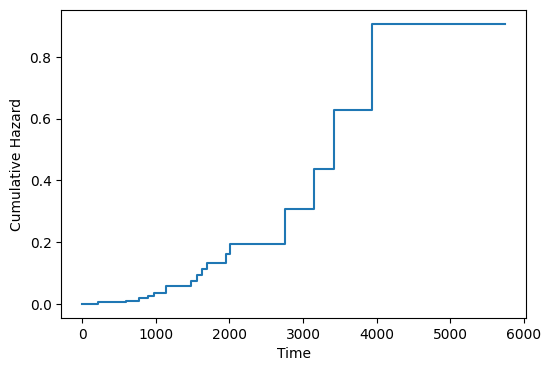

In [ ]:
# Plot cumulative hazard function for model

# Get the cumulative hazard function
cumulative_hazard = cph.baseline_cumulative_hazard_

# Plot the cumulative hazard function
plt.figure(figsize=(6, 4))
plt.step(cumulative_hazard.index, cumulative_hazard.values)
plt.xlabel('Time')
plt.ylabel('Cumulative Hazard')
plt.show()

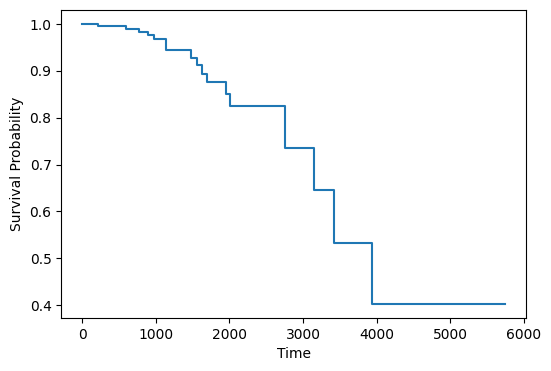

In [ ]:
# Plot baseline survival function for model

# Get the baseline survival function
baseline_survival = cph.baseline_survival_

# Plot the baseline survival function
plt.figure(figsize=(6, 4))
plt.step(baseline_survival.index, baseline_survival.values)
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

Text(0.5, 0, 'Time')

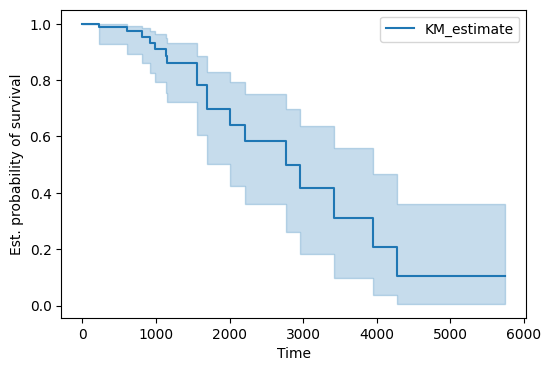

In [ ]:
# Plot survival curves for all patient records in dataset
kmf = KaplanMeierFitter()

kmf.fit(data['Time'],data['Event'])
plt.figure(figsize=(6, 4))
ax = kmf.plot_survival_function()
ax.set_ylabel("Est. probability of survival")
ax.set_xlabel("Time")


In [ ]:
# calculate risk scores for each patient
risk_scores = cph.predict_partial_hazard(data)

# classify patients into high vs low risk groups based on risk score
median_score = risk_scores.median()
high_risk_patients = data[risk_scores >= median_score]
low_risk_patients = data[risk_scores < median_score]

In [ ]:
# perform log-rank test for the two groups
results = logrank_test(high_risk_patients['Time'], low_risk_patients['Time'], event_observed_A=high_risk_patients['Event'], event_observed_B=low_risk_patients['Event'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           6.56 0.01      6.58

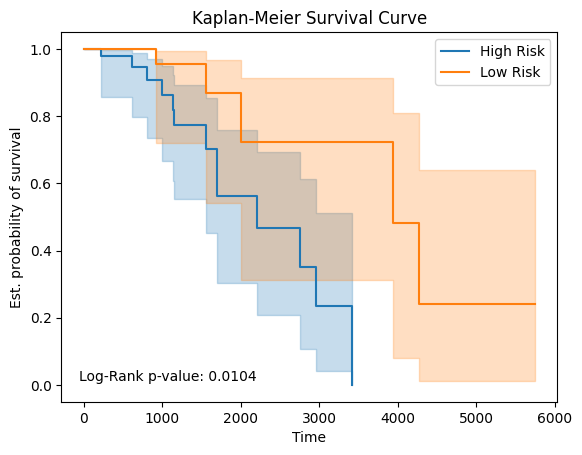

In [ ]:
# Fit and plot Kaplan-Meier Survival Curve for high-risk group
kmf.fit(high_risk_patients['Time'], event_observed=high_risk_patients['Event'], label='High Risk')
ax = kmf.plot_survival_function()

# Fit and plot Kaplan-Meier Survival Curve for low-risk group
kmf.fit(low_risk_patients['Time'], event_observed=low_risk_patients['Event'], label='Low Risk')
ax = kmf.plot_survival_function(ax=ax)

# Set axis labels and title
ax.set_ylabel("Est. probability of survival")
ax.set_xlabel("Time")
ax.set_title("Kaplan-Meier Survival Curve")
anchored_text = AnchoredText("Log-Rank p-value: {:.3}".format(results.p_value), loc=3, frameon=False, borderpad=0.9)
ax.add_artist(anchored_text)

In [ ]:
## Get top 10 high risk patients

#Get risk scores with record index
df_risk_scores = pd.DataFrame(risk_scores, index=data.index)

#Rename column and round to 3dp
df_risk_scores = df_risk_scores.rename(columns={df_risk_scores.columns[0]: 'Risk Scores'}).round(3)

#Rank risk scores
df_risk_scores = df_risk_scores.sort_values(by=['Risk Scores'], ascending=False)

#Get top 10 high risk patients
df_risk_scores.head(10)

,Risk Scores
44,29.190
60,9.232
18,7.337
63,5.329
54,5.143
1,4.761
53,4.761
55,4.761
16,4.761
7,4.761
